# Main Project File

## Imported Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve
)
from sklearn.calibration import calibration_curve
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from joblib import parallel_backend
import streamlit as st
import os
import csv

---

## Data Loading

In [2]:
filepath = "Streamlit_app/exoplanets data_Set.csv"
if not os.path.exists(filepath):
    raise FileNotFoundError(f"file {filepath} was not found. pls make sure it exists")

try:
    df = pd.read_csv(filepath, quoting=csv.QUOTE_ALL, comment="#")
    print(f"✅ successfully loaded {filepath}")
except Exception as e:
    raise ValueError(f"❌ error loading file {str(e)}")

✅ successfully loaded exoplanets data_Set.csv


---

## Data Preprocessing

In [3]:
features = [
    'koi_period', 'koi_duration', 'koi_depth', 'koi_prad',
    'koi_teq', 'koi_insol', 'koi_steff', 'koi_slogg', 'koi_srad'
]
target = "koi_disposition"

### Drop unnecessary cols

In [4]:
df = df[features + [target]]

### Drop missing targets

In [5]:
df = df.dropna(subset=[target])

### Fill NaNs in features

In [6]:
df[features] = df[features].fillna(df[features].median())

### Keep only binary labels

In [7]:
df = df[df[target].isin(['CONFIRMED', 'FALSE POSITIVE'])]

### Encode target

In [8]:
le = LabelEncoder()
df[target] = le.fit_transform(df[target])

### Train-test split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)


---

## Model Runner

In [10]:
def run_model(X_train, X_test, y_train, y_test,
              estimator=None, resampling=None,
              grid_search=False, grid_params=None, cv=None):

    numeric_col = X_train.select_dtypes('number').columns.values.tolist()

    preprocess_no_resampling = ColumnTransformer([
        ('ssc', StandardScaler(), numeric_col)
    ])

    # pipeline steps
    steps = [('preprocess', preprocess_no_resampling)]
    if resampling:
        steps.append(('rsm', resampling))
    steps.append(('clf', estimator))

    pipe = Pipeline(steps=steps)

    # grid search
    if grid_search:
        model = GridSearchCV(pipe, param_grid=grid_params, cv=cv, scoring="accuracy", n_jobs=-1)
    else:
        model = pipe

    with parallel_backend('threading', n_jobs=-1):
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return model, y_pred

---

## Training

In [11]:
params = [
    {
        'clf': (GradientBoostingClassifier(random_state=42),),
        'clf__n_estimators': [100, 500, 1000],
        'clf__max_features': [None, 'sqrt'],
        'clf__max_depth': [2, 3]
    }
]

model, y_pred = run_model(
    x_train, x_test, y_train, y_test,
    estimator=GradientBoostingClassifier(),
    grid_search=True, grid_params=params,
    cv=5
)

best_model = model.best_estimator_ if hasattr(model, "best_estimator_") else model


---

## Evaluation

In [12]:
precision = precision_score(y_test, y_pred, average="weighted")
rec = recall_score(y_test, y_pred, average="weighted")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)

info = pd.DataFrame({
    "f1 score": [f1],
    "accuracy": [accuracy],
    "recall score": [rec],
    "precision score": [precision]
})

print("\n📊 Model Performance:")
for key, value in info.iloc[0].items():
    print(f"{key}: {value:.4f}")


📊 Model Performance:
f1 score: 0.9044
accuracy: 0.9038
recall score: 0.9038
precision score: 0.9063


### Confusion Matrix

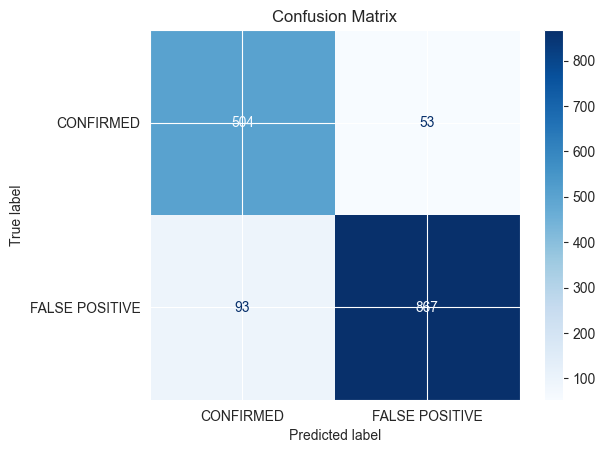

In [13]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

---

## Visualizations

### Class Distribution

C:\Users\Makrious\AppData\Local\Temp\ipykernel_10112\1572107092.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=le.inverse_transform(class_counts.index), y=class_counts.values, palette="viridis")


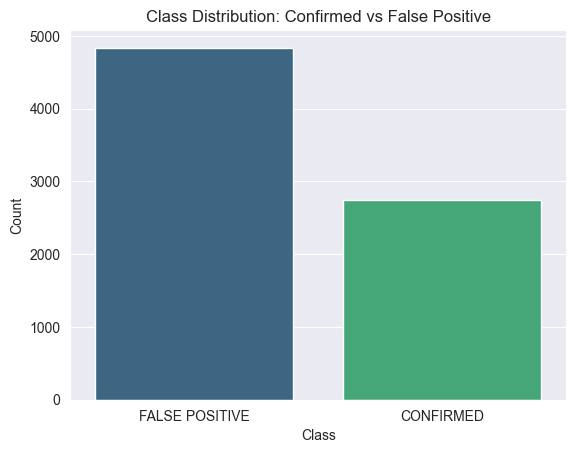

In [14]:
class_counts = df[target].value_counts()
sns.barplot(x=le.inverse_transform(class_counts.index), y=class_counts.values, palette="viridis")
plt.title("Class Distribution: Confirmed vs False Positive")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

### Feature Importance

C:\Users\Makrious\AppData\Local\Temp\ipykernel_10112\3779397789.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(features)[indices], palette="mako")


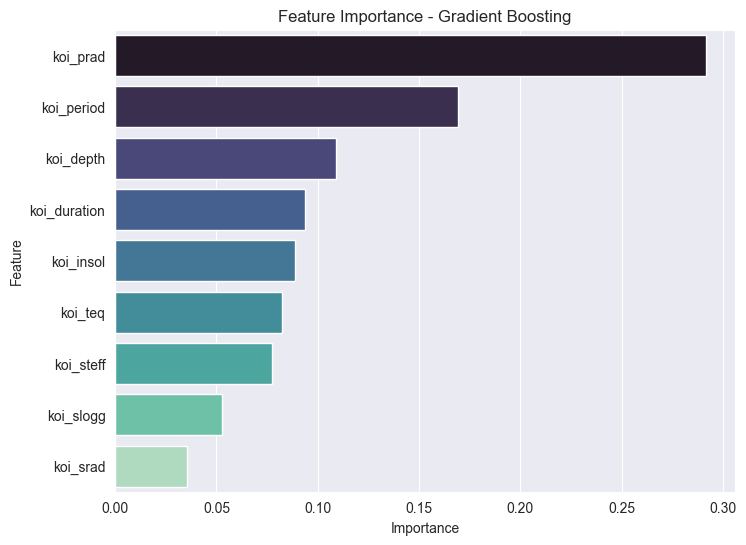

In [15]:
importances = best_model.named_steps['clf'].feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 6))
sns.barplot(x=importances[indices], y=np.array(features)[indices], palette="mako")
plt.title("Feature Importance - Gradient Boosting")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

### ROC curve

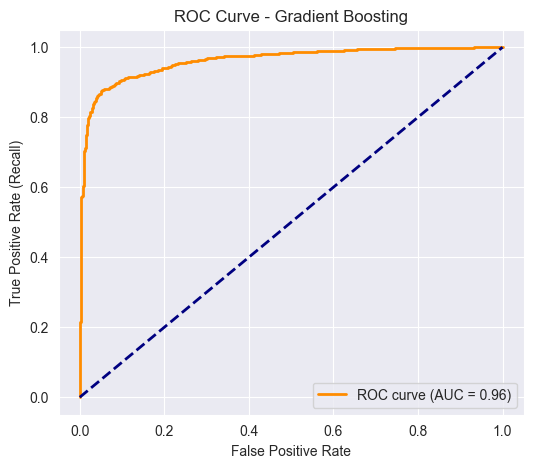

In [16]:
y_proba = best_model.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Gradient Boosting")
plt.legend(loc="lower right")
plt.show()

### Precision-Recall curve

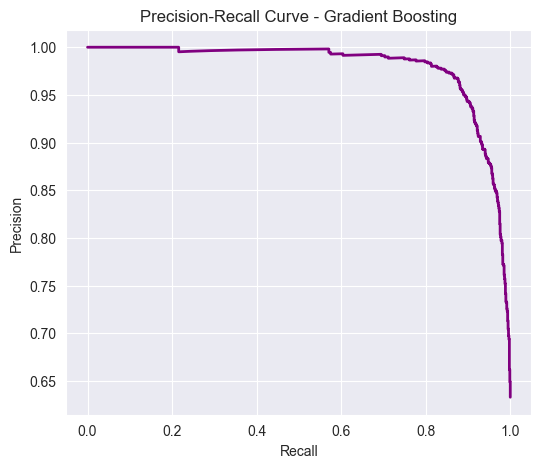

In [17]:
precisions, recalls, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, color="purple", lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Gradient Boosting")
plt.show()

### Learning curve

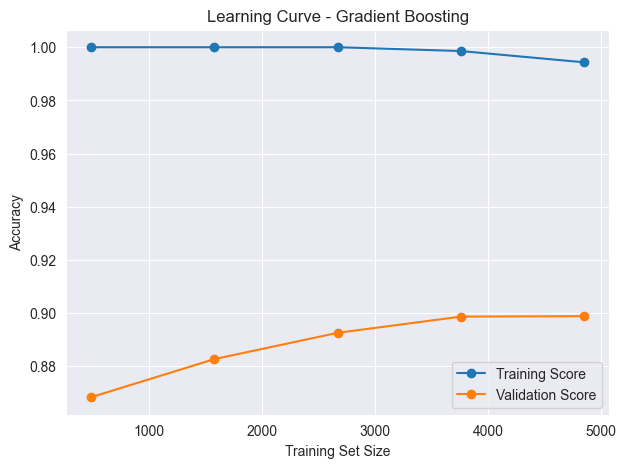

In [18]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model, x_train, y_train,
    cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring="accuracy"
)
plt.figure(figsize=(7, 5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), "o-", label="Training Score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), "o-", label="Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Gradient Boosting")
plt.legend(loc="best")
plt.show()

### Calibration curve

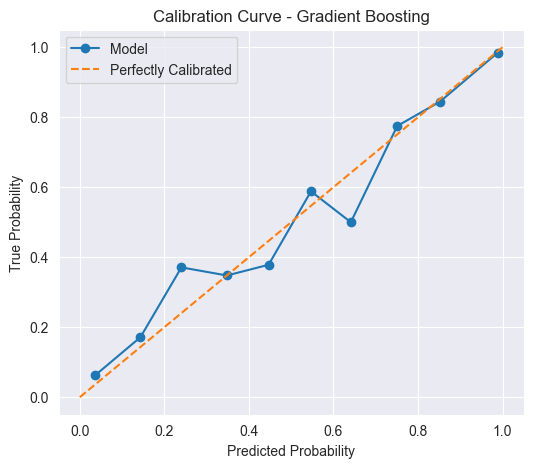

In [19]:
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly Calibrated")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve - Gradient Boosting")
plt.legend()
plt.show()

### Misclassifications

In [20]:
misclassified = x_test[y_test != y_pred].copy()
misclassified["True Label"] = y_test[y_test != y_pred]
misclassified["Predicted Label"] = y_pred[y_test != y_pred]
print("\n❌ Misclassified samples:")
print(misclassified.head(10))


❌ Misclassified samples:
      koi_period  koi_duration  koi_depth  koi_prad  koi_teq  koi_insol  \
953     2.495780        4.2721    25070.0     15.75   1408.0     929.47   
854   127.833500       10.9140     1829.9      9.46    554.0      22.21   
2995   35.080928        6.9200      100.7      1.21    610.0      32.63   
1835   23.554101        7.3000       95.2      2.33   1381.0     859.63   
3620    6.971069        3.9125      452.8      2.07    946.0     189.16   
8875    1.806631        1.1020      217.5      1.05   1059.0     297.98   
8324   12.817701        3.4650       75.6      1.21    999.0     235.16   
2197    2.622134        4.7350      128.2      1.64   1548.0    1359.14   
7871   11.931380        3.6390      122.1      0.56    415.0       7.00   
2254    5.266481        1.9640       97.8      1.07   1155.0     420.53   

      koi_steff  koi_slogg  koi_srad  True Label  Predicted Label  
953      6039.0      4.426     0.992           0                1  
854      650

### T-SNE

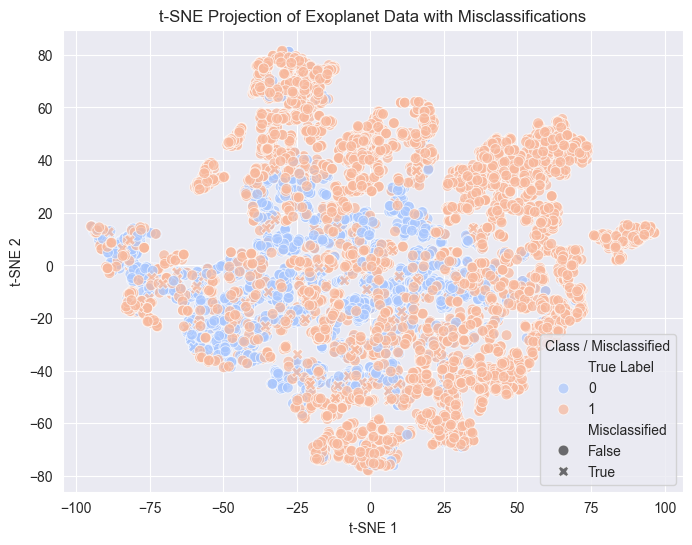

In [21]:
 scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(df[features])
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_all_scaled)

tsne_df = pd.DataFrame({
    "tSNE1": X_tsne[:, 0],
    "tSNE2": X_tsne[:, 1],
    "True Label": df[target].values
})
tsne_df["Predicted Label"] = best_model.predict(df[features])
tsne_df["Misclassified"] = tsne_df["True Label"] != tsne_df["Predicted Label"]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=tsne_df, x="tSNE1", y="tSNE2",
    hue="True Label", style="Misclassified",
    palette="coolwarm", alpha=0.7, s=60
)
plt.title("t-SNE Projection of Exoplanet Data with Misclassifications")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Class / Misclassified")
plt.show()

---